# Important Note:
I have included most related code in 

#### Installing and importing the dependencies

In [23]:
!pip install -r requirements.txt --quiet

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Prompt

# EDA (Exploratory Data Analysis)

<!-- "Victorious warriors win first and then go to war, while defeated warriors go to war first and then seek to win." - Sun Tzu, author of the Art of War. 
 -->
Sun Tzu, chinese philospher and military strategist, said it best with his timeless advice: 

**"Know thy self, know thy enemy. A thousand battles, a thousand victories."**

Applying this to our task, 

<!-- The COMMANDER stands for the virtues of wisdom, sincerity, benevolence, courage and strictness.
 -->


In [33]:
FILE_PATH = 'test.csv'
df = pd.read_csv(FILE_PATH)
print("--------------------")
print(f"Shape: {df.shape}")
print("--------------------")
df.head()

--------------------
Shape: (1459, 80)
--------------------


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [31]:
print(list(df.columns))

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC'

In [37]:
missing_data = describe_missing_data(df)
missing_data.head(10)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
MasVnrType,894,0.612748
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageYrBlt,78,0.053461
GarageQual,78,0.053461
GarageFinish,78,0.053461


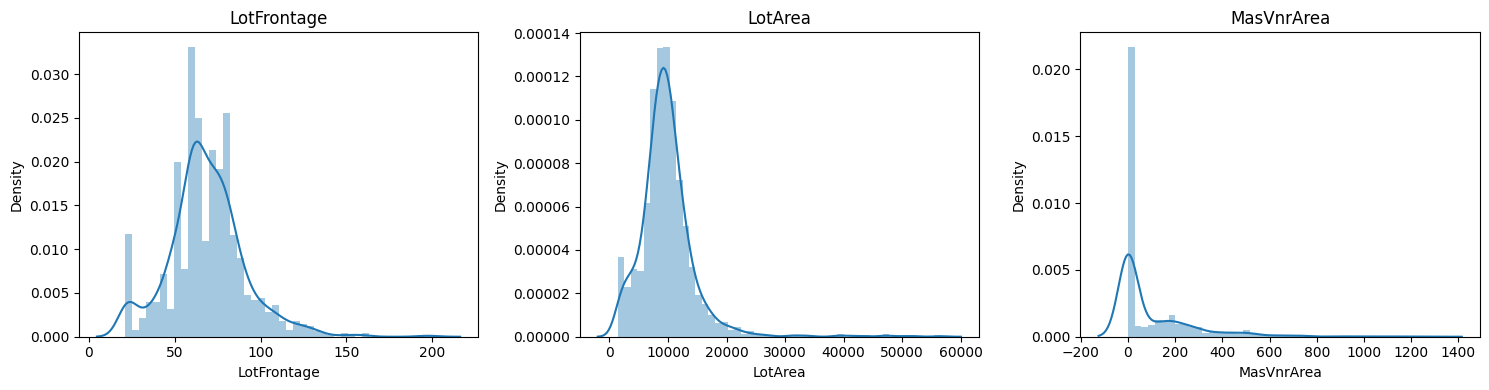

In [57]:
plot_multiple_continuous_distributions(['LotFrontage', 'LotArea', 'MasVnrArea'], df)

# Helper Functions - EXECUTE THIS CELL FIRST

In [56]:
def describe_missing_data(df):
    """Describes the null values present in our dataset"""
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

def plot_multiple_continuous_distributions(col_names, df):
    """Plot the distributions of the list of column names 
    from the dataframe, df."""
    
    num_cols = min(3, len(col_names))
    num_rows = (len(col_names) + 2) // 3  
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 4 * num_rows))
    axes = axes.flatten()
    
    for i, name in enumerate(col_names):
        sns.distplot(df[name], ax=axes[i])
        axes[i].set_title(name)
    
    for j in range(len(col_names), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    
def analyze_distribution(col_name, df): 
    ...
    
def remove_outliers_IQR():
    """Remove outliers using IQR from the dataset"""
    ...

def cluster_graph():
    ...

def cluster_classifier():
    ...

# sns.pairplot(df)
